In [1]:
import numpy as np  # NumPy for numerical computations
import matplotlib.pyplot as plt  # Matplotlib for plotting
from scipy import linalg as LA  # SciPy's linalg module for solving eigen problem

In [2]:
# Structure Definition

# Define the period in the x and y directions of the structure
period_x = 0.7
period_y = 0.7

In [3]:
# Incidence wave
wavelength = 0.530  # Wavelength of the incident wave (in micrometers)
k0 = np.pi * 2 / wavelength  # Wave number

AOI = np.deg2rad(10)  # Angle of incidence in radians
POI = np.deg2rad(20)  # Plane of incidence

k0x = np.sin(AOI) * np.cos(POI)  # x-component of the wave vector
k0y = np.sin(AOI) * np.sin(POI)  # y-component of the wave vector
k0z = np.cos(AOI)  # z-component of the wave vector

k0v = np.array([k0x, k0y, k0z])  # Wave vector

normal_vec = np.array([0, 0, 1], dtype='float')  # Normal vector to the surface

pol_vec_s = np.cross(normal_vec, k0v)  # Vector for s-polarization

# If the incident wave is perpendicular to the surface
if k0z == 1:
    pol_vec_s = np.array([0, 1, 0], dtype='float')

pol_vec_p = np.cross(pol_vec_s, k0v)  # Vector for p-polarization

pol_vec_s /= np.sqrt(np.sum(pol_vec_s**2))  # Normalize the s-polarization vector
pol_vec_p /= np.sqrt(np.sum(pol_vec_p**2))  # Normalize the p-polarization vector


In [4]:
def vis_vec(v, axis1=0, axis2=2, label=''):
    # This function visualizes a vector in a 2D plot
    # Input:
    #   v: The vector to be visualized
    #   axis1: The index of the first axis for plotting (default is 0)
    #   axis2: The index of the second axis for plotting (default is 2)
    #   label: Optional label for the vector (default is an empty string)

    # Plotting the vector using matplotlib
    plt.plot([0, v[axis1]], [0, v[axis2]], '-o', label=label)

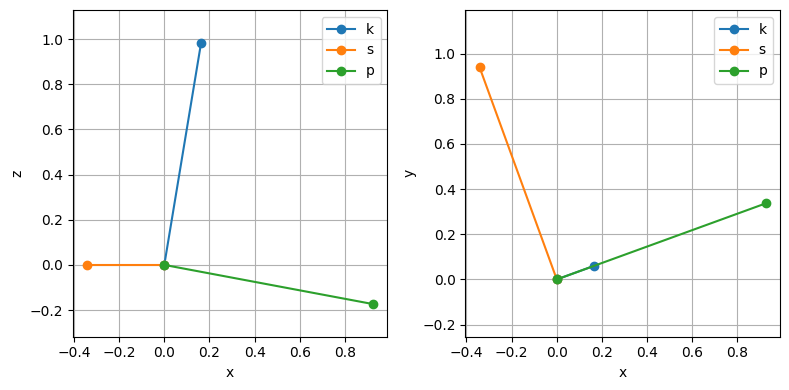

In [5]:
# Generate a figure with two subplots
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

# Visualize vectors k0v, pol_vec_s, and pol_vec_p
vis_vec(k0v, label='k')
vis_vec(pol_vec_s, label='s')
vis_vec(pol_vec_p, label='p')

plt.xlabel('x')
plt.ylabel('z')
plt.axis('equal')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
# Visualize vectors k0v, pol_vec_s, and pol_vec_p with respect to the y-axis
vis_vec(k0v, axis2=1, label='k')
vis_vec(pol_vec_s, axis2=1, label='s')
vis_vec(pol_vec_p, axis2=1, label='p')

plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.tight_layout()
plt.grid()
plt.legend()
plt.show()

In [6]:
# Special Frequency
# Calculate the spatial frequencies gx and gy based on the wavelength
# and period in the x and y directions
gx = wavelength / period_x  # Spatial frequency in the x-direction
gy = wavelength / period_y  # Spatial frequency in the y-direction

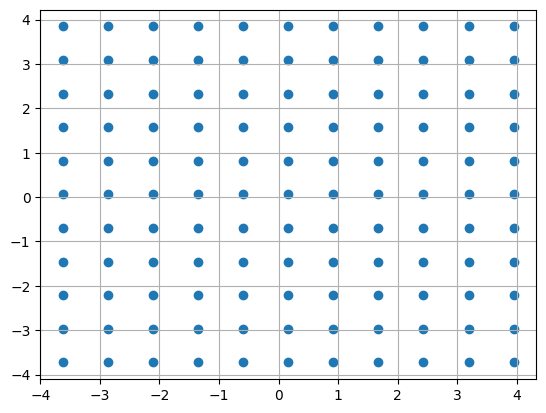

In [7]:
# Harmonics and mode number
num_harmonics_x = 5  # Number of x harmonics (-num to +num)
num_harmonics_y = 5  # Number of y harmonics (-num to +num)

num_modes_x = num_harmonics_x*2+1  # Number of x modes
num_modes_y = num_harmonics_y*2+1  # Number of y modes

num_modes = num_modes_x * num_modes_y  # Total number of modes


def ind2mode(id):
    # Ensure the mode ID is within the valid range
    id = id % num_modes

    # Calculate the mode indices in the x and y directions
    ix = id % num_modes_x
    iy = id // num_modes_x

    # Calculate the mode indices relative to the number of harmonics
    mx = ix - num_harmonics_x
    my = iy - num_harmonics_y

    # Return the mode indices as a tuple
    return mx, my

# Calculate the mode indices for each mode number
mx, my = ind2mode(np.arange(num_modes))

# Calculate the wave vectors in the x and y directions
kx = mx * gx + k0x  # Wave vector in the x-direction
ky = my * gy + k0y  # Wave vector in the y-direction

# Plot the wave vectors
plt.scatter(kx, ky)
plt.grid()
plt.show()


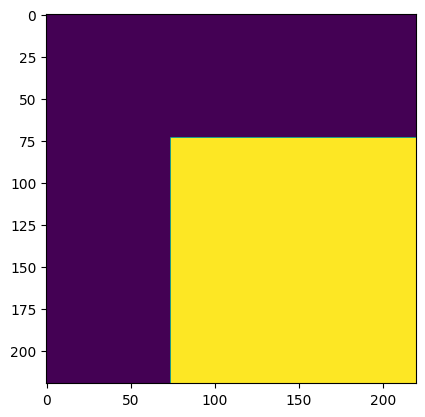

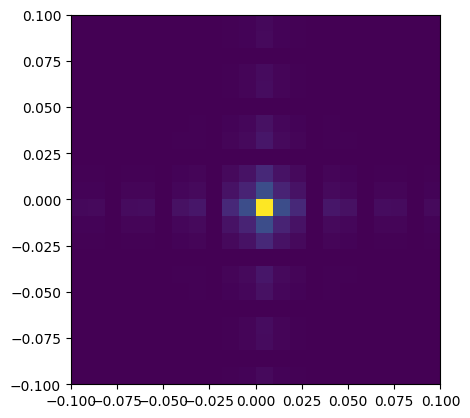

In [8]:
nx = num_modes_x * 20  # Number of sample points along the x-axis
ny = num_modes_y * 20  # Number of sample points along the y-axis

# Generating x and y coordinates
x = np.arange(nx) / nx * period_x
y = np.arange(ny) / ny * period_y
x, y = np.meshgrid(x, y)

# Defining a mask for grating shape
# mask = np.sin((y/period_y + x / period_x) * np.pi*2) / 2 + 0.5
# mask = x > period_x / 2
mask = (x > period_x / 3) * (y > period_x / 3)

# Displaying the mask
plt.imshow(mask)
plt.show()

n0 = 1  # Refractive index of the background medium
n1 = 2  # Refractive index of the region of interest

# Defining the dielectric constant (epsilon) and permeability (mu) distributions
er = (n1 ** 2 - n0 ** 2) * mask + n0 ** 2  # Dielectric constant distribution
ur = np.ones([ny, nx])  # Permeability distribution (uniform)

# Performing 2D Fourier transforms of the dielectric constant and permeability distributions
ft_er = np.fft.fft2(er)
ft_ur = np.fft.fft2(ur)

# Displaying the Fourier transforms
plt.imshow(np.fft.fftshift(np.abs(ft_er)), extent=[-1, 1, -1, 1])
plt.xlim([-0.1, 0.1])
plt.ylim([-0.1, 0.1])
plt.show()


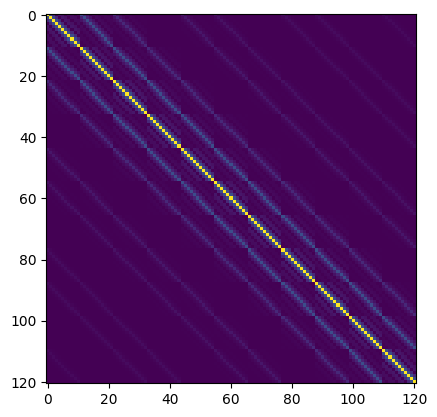

In [9]:
def conv_matrix(a):
    # Function to generate a convolution matrix
    
    # Generate indices for modes
    ind_prime = np.arange(num_modes)[None, :]
    ind = np.arange(num_modes)[:, None]
    
    # Convert indices to mode numbers
    mx_prime, my_prime = ind2mode(ind_prime)
    mx, my = ind2mode(ind)
    
    # Calculate indices for convolution
    ind_x = (mx - mx_prime) % nx
    ind_y = (my - my_prime) % ny
    
    # Perform convolution operation
    conv = a[ind_y, ind_x] / (nx * ny)
    
    return conv

# Calculate convolution matrices for er and ur
conv_er = conv_matrix(ft_er)  # Convolution matrix for er
conv_ur = conv_matrix(ft_ur)  # Convolution matrix for ur

# Plot the absolute values of the convolution matrix for er
plt.imshow(np.abs(conv_er))

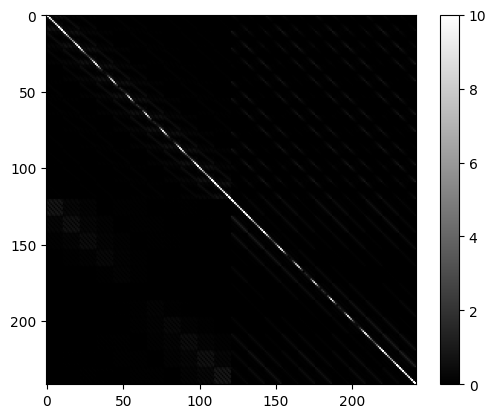

In [10]:
# Diagonal matrix with wave vector components in the x-direction
KX = np.diag(kx)
# Diagonal matrix with wave vector components in the y-direction
KY = np.diag(ky)


def Pmat(conv_er, conv_ur):
    # Calculate the P matrix based on the convolution of permittivity (conv_er) 
    # and permeability (conv_ur)
    er_inv_KX = np.linalg.solve(conv_er, KX)
    er_inv_KY = np.linalg.solve(conv_er, KY)
    P11 = KX @ er_inv_KY
    P12 = conv_ur - KX @ er_inv_KX
    P21 = KY @ er_inv_KY - conv_ur
    P22 = -KY @ er_inv_KX

    # Construct the P matrix using block matrix notation
    P = np.block([[P11, P12], [P21, P22]])
    return P


def PQmat(conv_er, conv_ur):
    # Calculate the P and Q matrices based on the convolution of 
    # permittivity (conv_er) and permeability (conv_ur)
    P = Pmat(conv_er, conv_ur)
    Q = Pmat(conv_ur, conv_er)
    return P, Q


# Calculate P and Q matrices using the given convolutions
P, Q = PQmat(conv_er, np.eye(conv_er.shape[0]))

omega2 = P @ Q  # Perform matrix multiplication of P and Q

# Display the absolute value of the resulting matrix
plt.imshow(np.abs(omega2), vmax=10, cmap='gray')
plt.colorbar()


In [11]:
def eigen_mode(P, Q):
    """
    Calculates the eigen modes of a system given P and Q matrices.

    Args:
        P (numpy.ndarray): P matrix.
        Q (numpy.ndarray): Q matrix.

    Returns:
        W (numpy.ndarray): Mode matrix describing the E field.
        V (numpy.ndarray): Mode matrix describing the H field .
        LAM (numpy.ndarray): Eigen-values corresponding to the mode propagation.
    """
    
    omega2 = P@Q
    LAM2, W = LA.eig(omega2)
    LAM = np.sqrt(LAM2)
    V=Q@W@np.diag(1/LAM)
    return W, V, LAM

W, V, LAM = eigen_mode(P, Q)

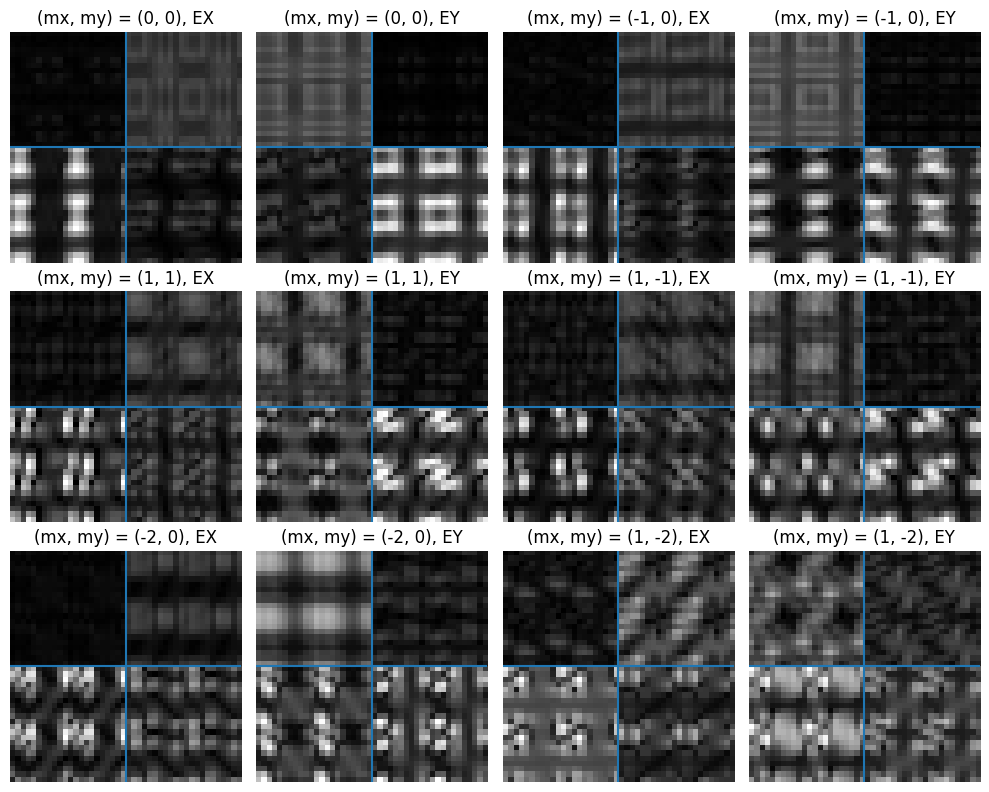

In [12]:
plt.figure(figsize=(10, 8))

mode_order = np.argsort(np.abs(mx)+np.abs(my))
# Loop through the range 20
for i in range(12):
    # Create subplots in a 5x4 grid
    plt.subplot(3, 4, i+1)



    j = i//2

    mode_ind = mode_order[j*3]

    mode_x = mx[mode_ind]
    mode_y = my[mode_ind]

    mode_mask = np.zeros(num_modes*2)
    mode_mask[mode_ind + i % 2*num_modes] = 1

    X = np.abs(np.exp(-LAM*100000))
    C = np.diag(X)@np.linalg.solve(W, mode_mask)

    # Extract the desired columns from W
    w = (W@C).reshape([
        2, num_modes_y, num_modes_x
    ])

    v = (V@C).reshape([
        2, num_modes_y, num_modes_x
    ])

    # Calculate the field by performing an inverse Fourier transform

    field_w = np.fft.fftshift(np.abs(np.fft.ifft2(w)))
    field_v = np.fft.fftshift(np.abs(np.fft.ifft2(v)))

    # Display the field as an image
    plt.title(f"(mx, my) = ({mode_x}, {mode_y}), {'EX' if i%2==0 else 'EY'}")
    plt.imshow(np.block([
        [field_w[0], field_w[0], field_w[1], field_w[1]],
        [field_w[0], field_w[0], field_w[1], field_w[1]],
        [field_v[0], field_v[0], field_v[1], field_v[1]],
        [field_v[0], field_v[0], field_v[1], field_v[1]],
    ]), cmap='gray', extent=[0, period_x, 0, period_y])

    plt.axvline(period_x/2)
    plt.axhline(period_y/2)

    # Hide the axis
    plt.axis(False)

# Adjust the layout of the subplots
plt.tight_layout()


In [13]:
num_modes*2

242

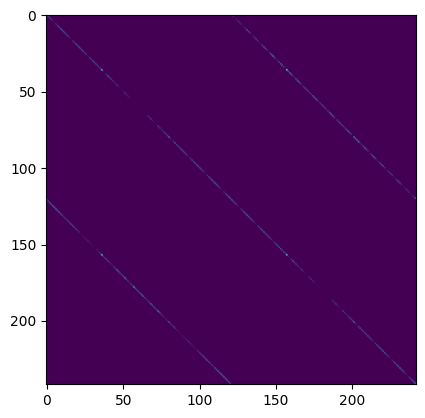

In [14]:
def homogeneous(er, ur):
    """
    Function to calculate the homogeneous layer parameters for RCWA.

    Args:
        er: Relative permittivity of the layer.
        ur: Relative permeability of the layer.

    Returns:
        W: Eigenmode matrix for E field.
        V: Eigenmode matrix for H field.
        LAM: Eigenvalues for the layer.
    """
    n2 = er * ur
    W = np.eye(num_modes*2)
    kz = np.sqrt((n2-kx**2-ky**2).astype('complex'))
    LAM = np.concatenate([1j * kz, 1j * kz])
    V11 = np.diag(kx*ky/kz)
    V12 = np.diag((n2-kx**2)/kz)
    V21 = np.diag((ky**2-n2)/kz)
    V22 = -V11
    V = -1j/ur*np.block([
        [V11, V12],
        [V21, V22],
    ])
    return W, V, LAM

W0, V0, LAM0 = homogeneous(1, 1)
Wref, Vref, LAMref = homogeneous(n0**2, 1)
Wtrn, Vtrn, LAMtrn = homogeneous(n1**2, 1)

plt.imshow(np.abs(Vtrn), vmax=10)


In [15]:
def StarProduct(A, B):
    # Redheffer star product

    # Extract elements from matrices A and B
    A11, A12, A21, A22 = A
    B11, B12, B21, B22 = B
    I = np.eye(A11.shape[0])

    # Compute intermediate matrices
    I_B11A22 = I-B11@A22
    I_A22B11 = I-A22@B11

    # Calculate elements of the Star Product matrix
    S11 = A12@np.linalg.solve(I_B11A22, B11@A21)+A11
    S12 = A12@np.linalg.solve(I_B11A22, B12)
    S21 = B21@np.linalg.solve(I_A22B11, A21)
    S22 = B21@np.linalg.solve(I_A22B11, A22@B12)+B22

    # Return the Star Product matrix
    return (S11, S12, S21, S22)


class ScatterMat:
    """
    Represents a scattering matrix for multilayer structures.

    The ScatterMat class encapsulates a scattering matrix that describes the
    transmission and reflection properties of a multilayer device. It provides
    functionality to perform matrix multiplication between scattering matrices
    using the '@' operator.

    Args:
        value (tuple): Tuple containing the elements of the scattering matrix.

    Attributes:
        value (tuple): The scattering matrix represented as a tuple of elements.

    Methods:
        __matmul__(self, other): Performs Redheffer star product with another scattering matrix.

    Usage Example:
        A = ScatterMat((A11, A12, A21, A22))
        B = ScatterMat((B11, B12, B21, B22))
        S = A @ B  # Perform Redheffer star product between scattering matrices A and B
    """

    def __init__(self, value) -> None:
        self.value = value

    def __matmul__(self, other):
        #
        A = self.value
        B = other.value
        S = ScatterMat(StarProduct(A, B))
        return S


In [16]:
def BuildScatter(W, V, LAM, L):
    """
    Function to build the scattering matrix
    for a multilayer structure using given inputs.

    Args:
        W: Matrix W.
        V: Matrix V.
        LAM: Eigen-value matrix.
        L: Layer thicknesses.

    Returns:
        ScatterMat: Scattering matrix of the multilayer structure.
    """
    WW = np.linalg.solve(W, W0)
    VV = np.linalg.solve(V, V0)
    A = WW+VV
    B = WW-VV
    X = np.diag(np.exp(-LAM*k0*L))
    AiX = np.linalg.solve(A, X)
    M = A-X@B@AiX@B
    S11 = np.linalg.solve(M, X@B@AiX@A-B)
    S12 = np.linalg.solve(M, X@(A-B@np.linalg.solve(A, B)))
    return ScatterMat((S11, S12, S12, S11))


def BuildScatterRef(W, V):
    """
    Function to build the reflection-side scattering matrix
    for a multilayer structure using given inputs.

    Args:
        W: Matrix W.
        V: Matrix V.

    Returns:
        ScatterMat: Reflection-side scattering matrix of the multilayer structure.
    """
    WW = np.linalg.solve(W, W0)
    VV = np.linalg.solve(V, V0)
    A = WW+VV
    B = WW-VV
    Ai = np.linalg.inv(A)
    S11 = np.linalg.solve(A.T, B.T).T
    S12 = 0.5*(A-S11@B)
    S21 = 2*Ai
    S22 = -np.linalg.solve(A, B)
    return ScatterMat((S11, S12, S21, S22))


def BuildScatterTrn(W, V):
    """
    Function to build the transmission-side scattering matrix
    for a multilayer structure using given inputs.

    Args:
        W: Matrix W.
        V: Matrix V.

    Returns:
        ScatterMat: Transmission-side scattering matrix of the multilayer structure.
    """
    WW = np.linalg.solve(W, W0)
    VV = np.linalg.solve(V, V0)
    A = WW+VV
    B = WW-VV
    Ai = np.linalg.inv(A)
    S11 = -np.linalg.solve(A, B)
    S12 = 2*Ai
    S22 = np.linalg.solve(A.T, B.T).T
    S21 = 0.5*(A-S22@B)
    return ScatterMat((S11, S12, S21, S22))


In [17]:
# Build scattering matrix for reflection
Sref = BuildScatterRef(Wref, Vref)
# Build scattering matrix (S)
S = BuildScatter(W, V, LAM, 0.25)
# Build scattering matrix for transmission
Strn = BuildScatterTrn(Wtrn, Vtrn)
# Build global scattering matrix
Sglobal = Sref @ S @ Strn

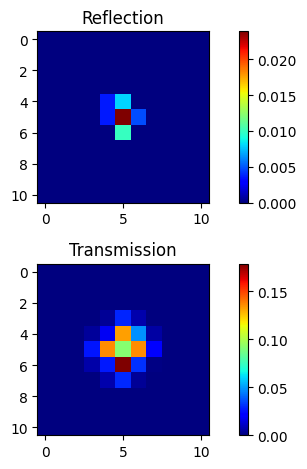

1.000000000005189
Error: -5.188960372493057e-12


In [18]:
delta = (mx == 0)*(my == 0)

# Set amplitudes for s and p polarizations
amp_s = 0
amp_p = 1

# Calculate the polarization vector based on s and p amplitudes
pol = pol_vec_p * amp_p + pol_vec_s * amp_s

# Calculate the incident electric field components
Einc = np.concatenate([delta*pol[0], delta*pol[1]])
Einc_z = delta*pol[2]

# Calculate the incident intensity
Iinc = np.sum(np.abs(Einc)**2)+np.sum(np.abs(Einc_z)**2)

# Calculate the longitudinal wave vector components
kz_r = np.sqrt((n0**2-kx**2-ky**2).astype('complex'))
kz_t = np.sqrt((n1**2-kx**2-ky**2).astype('complex'))

def incidence(S):
    # Calculate the electric field components using the scattering matrix
    Eref = (S.value[0]@Einc).reshape([2, -1])
    Etrn = (S.value[2]@Einc).reshape([2, -1])

    # Calculate the longitudinal electric field components
    Eref_z = -(Eref[0]*kx+Eref[1]*ky)/kz_r
    Etrn_z = -(Etrn[0]*kx+Etrn[1]*ky)/kz_t

    # Calculate the reflected and transmitted intensities
    Iref = np.sum(np.abs(Eref)**2, 0)+np.abs(Eref_z)**2
    Itrn = np.sum(np.abs(Etrn)**2, 0)+np.abs(Etrn_z)**2

    # Calculate the reflection and transmission coefficients
    R = Iref*np.real(kz_r)/k0z/Iinc
    T = Itrn*np.real(kz_t)/k0z/Iinc

    return Eref, Etrn, R, T


Eref, Etrn, R, T = incidence(Sglobal)
# Reshape the reflection and transmission coefficients into 2D arrays
R_2d = np.reshape(R, [num_modes_y, num_modes_x])
T_2d = np.reshape(T, [num_modes_y, num_modes_x])

# Plot the reflection and transmission coefficients
plt.subplot(2, 1, 1)
plt.title("Reflection")
plt.imshow(R_2d, cmap='jet', vmin=0)
plt.colorbar()
plt.subplot(2, 1, 2)
plt.title("Transmission")
plt.imshow(T_2d, cmap='jet', vmin=0)
plt.colorbar()
plt.tight_layout()
plt.show()

# Calculate the sum of reflection and transmission coefficients
print(np.sum(R+T))
print("Error:", 1-np.sum(R+T))


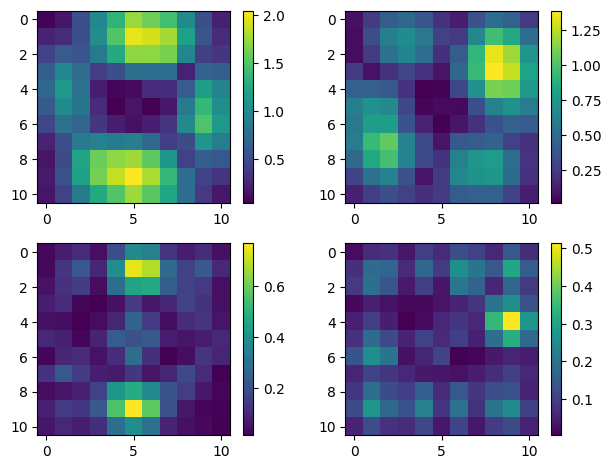

In [19]:
Erefx_2d = np.reshape(Eref[0], [num_modes_y, num_modes_x])
Erefy_2d = np.reshape(Eref[1], [num_modes_y, num_modes_x])
Etrnx_2d = np.reshape(Etrn[0], [num_modes_y, num_modes_x])
Etrny_2d = np.reshape(Etrn[1], [num_modes_y, num_modes_x])

plt.subplot(2, 2, 1)
plt.imshow(np.abs(Erefx_2d))
plt.colorbar()
plt.subplot(2, 2, 2)
plt.imshow(np.abs(Erefy_2d))
plt.colorbar()
plt.subplot(2, 2, 3)
plt.imshow(np.abs(Etrnx_2d))
plt.colorbar()
plt.subplot(2, 2, 4)
plt.imshow(np.abs(Etrny_2d))
plt.colorbar()
plt.tight_layout()
plt.show()


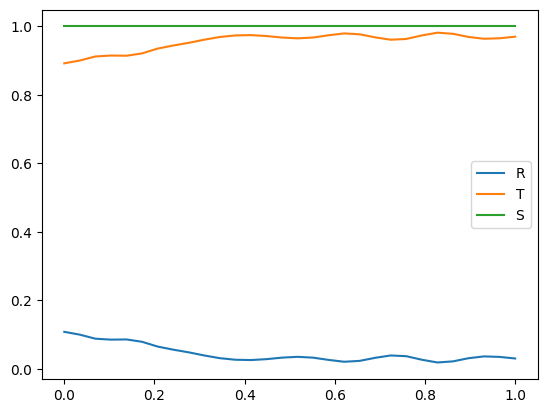

In [20]:
L = np.linspace(0, 1, 30)
Rs = []
Ts = []
for l in L:
    S = BuildScatter(W, V, LAM, l)
    Sglobal = Sref @ S @ Strn
    Eref, Etrn, R, T = incidence(Sglobal)

    Rs.append(R)
    Ts.append(T)

Rs = np.array(Rs)
Ts = np.array(Ts)

plt.plot(L, np.sum(Rs, 1), label='R')
plt.plot(L, np.sum(Ts, 1), label='T')
plt.plot(L, np.sum(Rs+Ts, 1), label='S')
plt.legend()
plt.show()

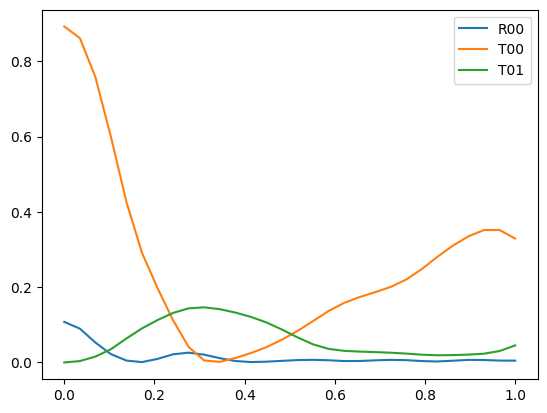

In [21]:
plt.plot(L, np.sum(Rs*((mx==0)*(my==0))[None, :], 1), label='R00')
plt.plot(L, np.sum(Ts*((mx==0)*(my==0))[None, :], 1), label='T00')
plt.plot(L, np.sum(Ts*((mx==1)*(my==0))[None, :], 1), label='T01')
plt.legend()
plt.show()